# Air Quality Forecasts
The CAMS service provides the [Air Quality Forecasts for Europe](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts). The data product is based on an ensemble of the outputs of nine Earth System models that provides the forecasts for many polluttants such as NOx, Ozone, particulate matter (PM2.5 and PM10) and SO2. In this experiment we want to retrieve the forecasts for NO2 over the Italian peninsula at ground level for the next 24, 48 and 72 hours (lead times) and visualize the forecasts as a sequence in a GIF. More information about the origin of NO2 and its relevance on the air quality is available at the [EUMETSAT website](https://training.eumetsat.int/mod/page/view.php?id=13823)

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cdsapi
from platform import python_version
print("python version: %s"%python_version())
print("pandas version: %s"%pd.__version__)
print("xarray version: %s"%xr.__version__)

python version: 3.8.2
pandas version: 1.0.2
xarray version: 0.14.0


We set some parameter before submitting our request

In [2]:
path = 'data/air_quality_forecasts/20201203'
file_name = 'air_quality_forecasts_europe_20201203.nc'
date = '2020-12-03'

In [15]:
#URL = "https://ads.atmosphere.copernicus.eu/api/v2"
#KEY = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
#c = cdsapi.Client(url=URL, key=KEY)

c = cdsapi.Client()

c.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'model': 'ensemble',
        'date': date + '/' + date,
        'format': 'netcdf',
        'variable': 'nitrogen_dioxide',
        'level': '0',
        'type': 'forecast',
        'time': '00:00',
        'leadtime_hour': [
            '24', '48', '72',
        ],
        'area': [
            47.12, 6.57, 36.4,
            18.52,
        ],
    },
    path + '/' + file_name)

2020-12-03 16:50:28,489 INFO Welcome to the CDS
2020-12-03 16:50:28,491 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
2020-12-03 16:50:28,583 INFO Request is queued
2020-12-03 16:50:29,665 INFO Request is running
2020-12-03 16:50:31,250 INFO Request is completed
2020-12-03 16:50:31,254 INFO Downloading http://136.156.133.80/cache-compute-0002/cache/data1/adaptor.cams_regional_fc.retrieve-1607007029.6589816-1396-5-db43c0e9-596c-4fdb-aa47-7a6d8b97558c.nc to data/air_quality_forecasts/20201203/air_quality_forecasts_europe_20201203.nc (151.3K)
2020-12-03 16:50:31,982 INFO Download rate 208.7K/s


Result(content_length=154944,content_type=application/x-netcdf,location=http://136.156.133.80/cache-compute-0002/cache/data1/adaptor.cams_regional_fc.retrieve-1607007029.6589816-1396-5-db43c0e9-596c-4fdb-aa47-7a6d8b97558c.nc)

If we have requested the forecasts starting from only day, let's say the day in which we send the request, the webservice will send a netcdf file with the forecasts for all the lead times we have specified. If we want the forecasts starting from more days the webservice will send a zip file that contains one netCDF file for each start day. In our test we will request the forecasts starting from one single day, the same day in which we send the request.  

In [16]:
#import os
#import zipfile
#with zipfile.ZipFile('data/air_quality_forecasts_europe_20201203.zip', 'r') as zip_ref:
#    zip_ref.extractall(path)

#nc_files = os.listdir(path)
#nc_files

Let's open the file to get the NO2 forecasts

In [3]:
def getforecast(path, file_name):
    # The forecasts for NO2 are in the 'no2_conc' variable. 
    # The function puts the data in memory, closes the file
    # and returns the NO2 forecast
    ds = xr.open_dataset(path + '/' + file_name)
    no2_forecast = ds['no2_conc']
    ds.close()
    return no2_forecast

In [4]:
no2_forecasts = getforecast(path, file_name)
no2_forecasts

<xarray.DataArray 'no2_conc' (time: 3, level: 1, latitude: 107, longitude: 119)>
array([[[[ 1.949255, ...,  4.303936],
         ...,
         [12.589611, ...,  1.638641]]],


       ...,


       [[[ 6.190485, ...,  3.02894 ],
         ...,
         [ 5.575639, ...,  0.916063]]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 6.65 6.75 6.85 6.95 ... 18.25 18.35 18.45
  * latitude   (latitude) float32 47.05 46.95 46.85 46.75 ... 36.65 36.55 36.45
  * level      (level) float32 0.0
  * time       (time) timedelta64[ns] 1 days 2 days 3 days
Attributes:
    species:        Nitrogen Dioxide
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_nitrogen_dioxide_in_air

As we can see from the description, the time interval of each forecast is provided as a delta in nanoseconds (ns), from the first day to the second day, that is 86400 * 10^9, or 86400000000000, nanoseconds, then from the first day to the third and so on. We will create a date time index to be used later on in the plots 

In [57]:
delta_time = 86400000000000
num_days = len(no2_forecasts)
start_day = pd.to_datetime(date)
date_index = start_day + pd.to_timedelta(np.arange(3), 'D')
date_index

DatetimeIndex(['2020-12-03', '2020-12-04', '2020-12-05'], dtype='datetime64[ns]', freq=None)

We plot the forecast for the first day and then we'll create an animation using all the forecasts. 

In [65]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
print("matplotlib version: %s"%matplotlib.__version__)
print("cartopy version: %s"%cartopy.__version__)

matplotlib version: 3.3.1
cartopy version: 0.18.0


We create the figure that we will use to plot the data

In [66]:
def create_figure(): 
    fig = plt.figure(figsize=(10,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND, edgecolor='black')
    ax.coastlines()
    return fig, ax

Let's plot the first forecast. 

Text(0.5, 1.0, 'Air Quality Forecast - 2020-12-03 00:00:00')

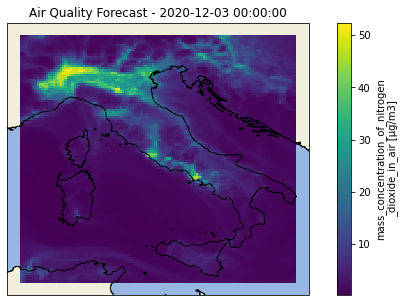

In [68]:
_, ax = create_figure()
first_forecast = no2_forecasts.sel(level = 0.0, time = delta_time)
first_forecast.plot.pcolormesh(ax=ax, 
                                x='longitude', 
                                y='latitude', 
                                add_colorbar=True, cmap='viridis')
plt.title('Air Quality Forecast - {0:s}'.format(date_index[0].strftime('%Y-%m-%d %H:%M:%S')))

Now we create the animation using all the forecasts at ground level.

In [69]:
import matplotlib.animation as animation
from IPython.display import HTML, display

forecasts = no2_forecasts.sel(level = 0.0)

def draw(frame, add_colorbar):    
    forecast_frame = forecasts.sel(time = delta_time * frame)
    plot = forecast_frame.plot.pcolormesh(ax=ax, x='longitude', y='latitude', add_colorbar=add_colorbar, cmap='viridis')
    title = 'Air Quality Forecast - {0:s}'.format(date_index[frame - 1].strftime('%Y-%m-%d %H:%M:%S'))
    ax.set_title(title)
    return plot

def init():
    return draw(1, add_colorbar=True)

def animate(frame):
    plt.close()
    return draw(frame + 1, add_colorbar=False)

fig, ax = create_figure()


ani = animation.FuncAnimation(fig, animate, frames=3, interval=1000, blit=False, init_func=init, repeat=False)

HTML(ani.to_jshtml())

In [72]:
ani.save('images/no2_forecasts.mp4', writer=animation.FFMpegWriter(fps=1))

In [73]:
display(HTML("<video controls><source src='images/no2_forecasts.mp4' type='video/mp4'></video>"))